# Football Events and Game Information

Refer to the project ReadMe.md to get a glimpse of what the project is about.

# Imports and initializations

In [1]:
# imports used in the project

import zipfile
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import venn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from pandas.tools.plotting import scatter_matrix

In [2]:
# plots descriptions

plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=(5,5))

# Data Processing and Engineering 

## Import the data from CSV into appropriate python data structures

In [3]:
# Read the data from CSV files into pandas data frame

df_events = pd.read_csv("Data/events.csv")
df_game_info = pd.read_csv("Data/ginf.csv")

In [4]:
# Encode the data into respective data frames

encoding = pd.read_table('Data/dictionary.txt', delim_whitespace=False, names=('num','events'))
event_type=encoding[1:13]
event_type_2=encoding[14:18]
side=encoding[19:21]
shot_place=encoding[22:35]
shot_outcome=encoding[36:40]
location=encoding[41:60]
bodypart=encoding[61:64]
assist_method=encoding[65:70]
situition=encoding[71:75]

In [5]:
# Manually convert the dictionary.txt to python dictionaries

event_types = {1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}
event_types2 = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
sides = {1:'Home', 2:'Away'}
shot_places = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}
shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
locations = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}
bodyparts = {1:'right foot', 2:'left foot', 3:'head'}
assist_methods = {1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}

In [6]:
## Map the leagues' names to their popular names for easier understanding
leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
          'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

## Map them to events
df_game_info.league = df_game_info.league.map(leagues)

In [7]:
# Map the dictionaries onto the events dataframe

df_events['event_type'] =   df_events['event_type'].map(event_types)
df_events['event_type2'] =  df_events['event_type2'].map(event_types2)
df_events['side'] =         df_events['side'].map(sides)
df_events['shot_place'] =   df_events['shot_place'].map(shot_places)
df_events['shot_outcome']=  df_events['shot_outcome'].map(shot_outcomes)
df_events['location'] =     df_events['location'].map(locations)
df_events['bodypart'] =     df_events['bodypart'].map(bodyparts)
df_events['assist_method']= df_events['assist_method'].map(assist_methods)
df_events['situation'] =    df_events['situation'].map(situations)

## Data Engineering

In [8]:
# Merge other dataset to have country, league, date and season
df_events = df_events.merge(df_game_info ,how = 'left')

In [9]:
df_game_info.season = df_game_info.season.astype('category')
df_game_info.league = df_game_info.league.astype('category')
df_game_info.country = df_game_info.country.astype('category')

In [10]:
df_game_info.league.unique()

[Bundesliga, League One, Premier League, La Liga, Serie A]
Categories (5, object): [Bundesliga, League One, Premier League, La Liga, Serie A]

In [11]:
assist_method

,num,events
65,0,None
66,1,Pass
67,2,Cross
68,3,Headed pass
69,4,Through ball


### Handle Missing Values

In [12]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
missing_values_table(df_events)

Your selected dataframe has 39 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
player_in,889294,94.5
player_out,889271,94.5
odd_over,842329,89.5
odd_under,842329,89.5
odd_bts,842329,89.5
odd_bts_n,842329,89.5
assist_method,773104,82.2
event_type2,726716,77.2
shot_place,713550,75.8
shot_outcome,712511,75.7


In [14]:
# Fill the required features with new class 'unknown'
df_events.shot_place.fillna('UNK', inplace= True)
df_events.player.fillna('UNK', inplace= True)
df_events.shot_outcome.fillna('UNK', inplace= True)
df_events.bodypart.fillna('UNK', inplace= True)
df_events.location.fillna('UNK', inplace= True)
df_events.assist_method.fillna('UNK', inplace= True);

In [15]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 39 columns):
id_odsp          941009 non-null object
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null object
event_type2      214293 non-null object
side             941009 non-null object
event_team       941009 non-null object
opponent         941009 non-null object
player           941009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       941009 non-null object
shot_outcome     941009 non-null object
is_goal          941009 non-null int64
location         941009 non-null object
bodypart         941009 non-null object
assist_method    941009 non-null object
situation        229137 non-null object
fast_break       941009 non-null int64
link_odsp      

In [16]:
# Notice that a lot of the floats and ints are in fact categoricals
# We can fix this with Pandas' astype function
categoricals = ['id_odsp', 'event_type', 'event_team', 'opponent', 'shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation', 'side']
d = dict.fromkeys(categoricals,'category')
df_events = df_events.astype(d)
df_events['is_goal'] = df_events['is_goal'].astype('bool') # this is a bool, we can fix that too while we're at it

In [17]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 39 columns):
id_odsp          941009 non-null category
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null category
event_type2      214293 non-null object
side             941009 non-null category
event_team       941009 non-null category
opponent         941009 non-null category
player           941009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       941009 non-null category
shot_outcome     941009 non-null category
is_goal          941009 non-null bool
location         941009 non-null category
bodypart         941009 non-null category
assist_method    941009 non-null category
situation        229137 non-null category
fast_break       941009 non-null 

# Data Analysis and Visualisations

### Create the cards dataframes

In [18]:
df_unique_events = df_events.drop_duplicates() 

In [19]:
# Get the yellow cards data

first_yellow_cards = df_unique_events [df_unique_events ['event_type'] == ('Yellow card')] # select first yellow cards
second_yellow_cards= df_unique_events [df_unique_events ['event_type'] == ('Second yellow card')] # select second yellow cards
red_cards = df_unique_events [df_unique_events['event_type'] == ('Red card')] # select red cards
yellow_cards= df_unique_events [df_unique_events ['event_type'] == ('Yellow card' or 'Second yellow card')]

card_frames = [red_cards, yellow_cards]
all_cards = pd.concat(card_frames)


### Graph to show when red cards are most likely to be served

Text(0.5, 1.0, 'When Red Cards Occur')

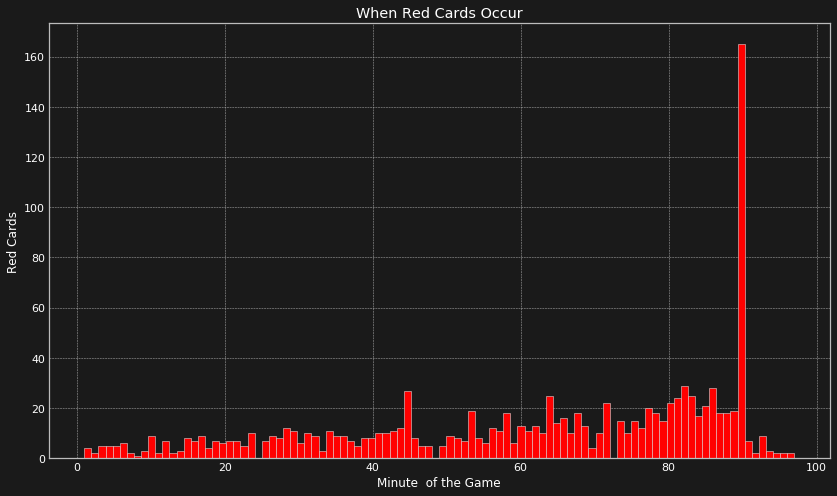

In [20]:
# Get the yellow cards against time of playing the game
fig = plt.figure(figsize=(14,8))
plt.hist(red_cards.time, 100, color="red")
plt.xlabel("Minute  of the Game")
plt.ylabel("Red Cards")
plt.title("When Red Cards Occur")



### Graph to show when the yellow cards are most likely to be served

Text(0.5, 1.0, 'When First Yellow Cards Occur')

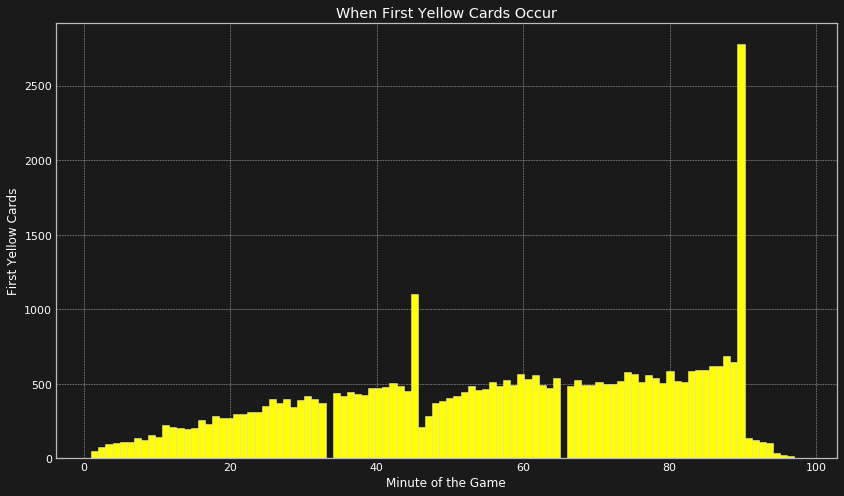

In [21]:
# plot the second yellow cards against time of playing the game

fig2 = plt.figure(figsize=(14,8))
plt.hist(first_yellow_cards.time, 100, color="yellow")
plt.xlabel("Minute of the Game")
plt.ylabel("First Yellow Cards")
plt.title("When First Yellow Cards Occur")



,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
44,UFot0hit/,UFot0hit45,45,45,Michael Mancienne (Hamburg) is shown the yello...,Yellow card,NaN,Away,Hamburg SV,Borussia Dortmund,michael mancienne,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
76,UFot0hit/,UFot0hit77,77,68,Gojko Kacar (Hamburg) is shown the yellow card...,Yellow card,NaN,Away,Hamburg SV,Borussia Dortmund,gojko kacar,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
79,UFot0hit/,UFot0hit80,80,69,Tomas Rincon (Hamburg) is shown the yellow car...,Yellow card,NaN,Away,Hamburg SV,Borussia Dortmund,tomas rincon,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
101,UFot0hit/,UFot0hit102,102,85,Robert Lewandowski (Borussia Dortmund) is show...,Yellow card,NaN,Home,Borussia Dortmund,Hamburg SV,robert lewandowski,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
118,Aw5DflLH/,Aw5DflLH9,9,5,Marcel de Jong (FC Augsburg) is shown the yell...,Yellow card,NaN,Home,FC Augsburg,SC Freiburg,marcel de jong,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
125,Aw5DflLH/,Aw5DflLH16,16,10,Tobias Werner (FC Augsburg) is shown the yello...,Yellow card,NaN,Home,FC Augsburg,SC Freiburg,tobias werner,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
153,Aw5DflLH/,Aw5DflLH44,44,29,Oliver Barth (SC Freiburg) is shown the yellow...,Yellow card,NaN,Away,SC Freiburg,FC Augsburg,oliver barth,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
192,Aw5DflLH/,Aw5DflLH83,83,61,Daniel Caligiuri (SC Freiburg) is shown the ye...,Yellow card,NaN,Away,SC Freiburg,FC Augsburg,daniel caligiuri,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
218,Aw5DflLH/,Aw5DflLH109,109,85,Mensur Mujdza (SC Freiburg) is shown the yello...,Yellow card,NaN,Away,SC Freiburg,FC Augsburg,mensur mujdza,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
231,Aw5DflLH/,Aw5DflLH122,122,90,Johannes Flum (SC Freiburg) is shown the yello...,Yellow card,NaN,Away,SC Freiburg,FC Augsburg,johannes flum,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN


### Graph to show when the second yellow cards are most likely to be served

Text(0.5, 1.0, 'When Second Yellow Cards Occur')

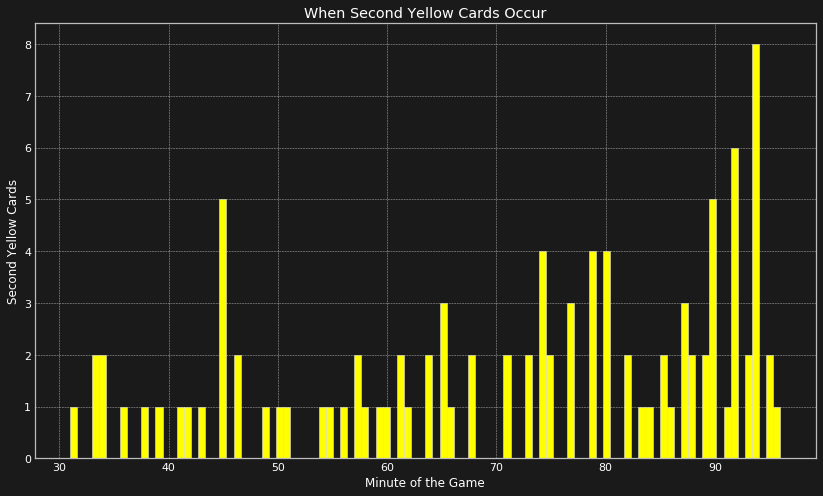

In [22]:
# plot the red cards against time of playing the game

fig3 = plt.figure(figsize=(14,8))
plt.hist(second_yellow_cards.time, 100, color="yellow")
plt.xlabel("Minute of the Game")
plt.ylabel("Second Yellow Cards")
plt.title("When Second Yellow Cards Occur")



### Generally when are cards likely to be served

Text(0.5, 1.0, 'When cards are served')

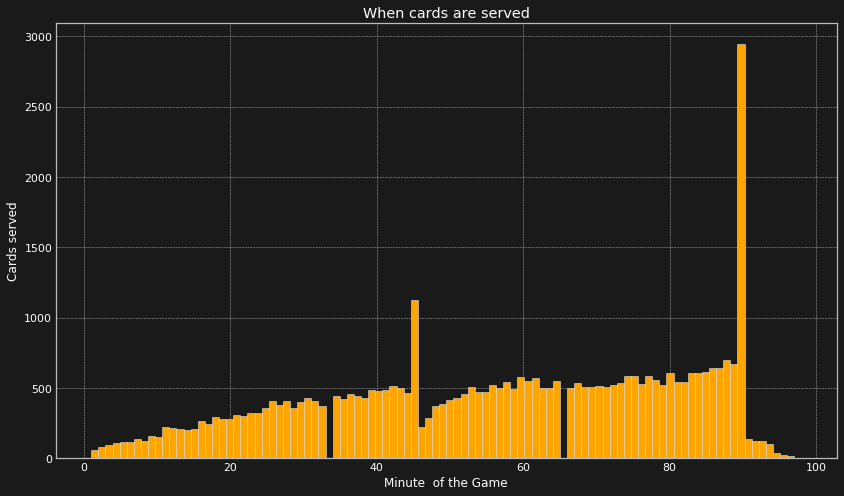

In [23]:
# Get the yellow cards against time of playing the game
fig4 = plt.figure(figsize=(14,8))                                                            
plt.hist(all_cards.time, 100, color="orange")
plt.xlabel("Minute  of the Game")
plt.ylabel("Cards served")
plt.title("When cards are served")


### Distribution of serving of yellow cards as per the leagues

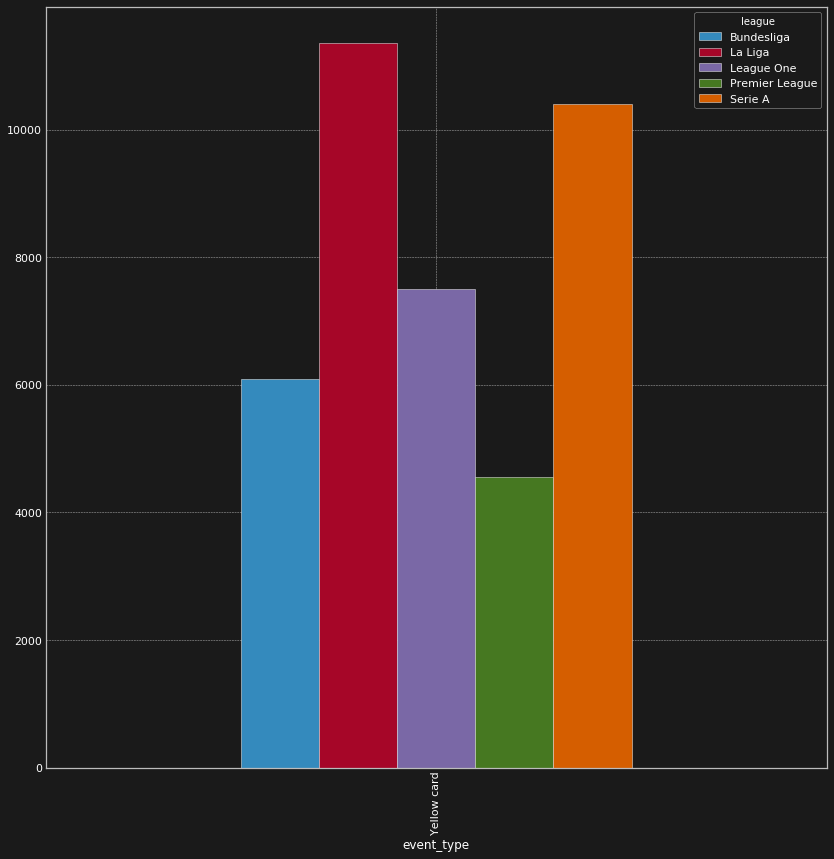

In [24]:
yellow_league = pd.crosstab(index=yellow_cards.event_type, columns=yellow_cards.league)
yellow_league.plot(kind='bar', figsize=(14,14))


### Distibution of red cards as per the league

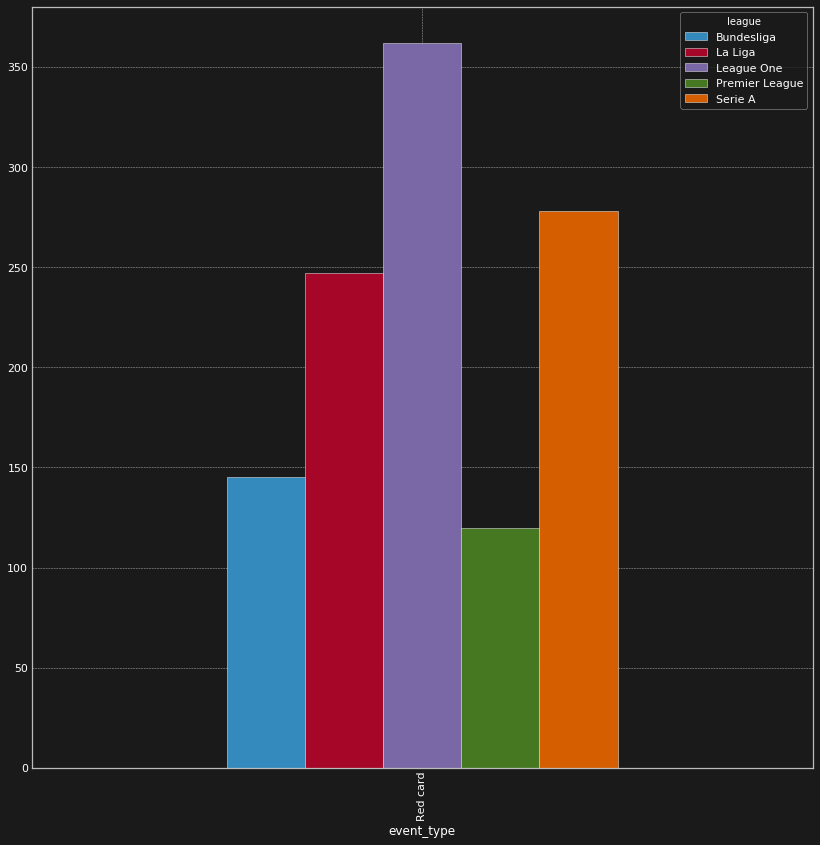

In [25]:
red_league = pd.crosstab(index=red_cards.event_type, columns=red_cards.league)
red_league .plot(kind='bar', figsize=(14,14))

### Get cards served per league

In [26]:
player_red_card = (red_cards[['player', 'league']])
league_one = player_red_card [player_red_card.league == 'League One'].groupby('player').count()
La_Liga = player_red_card [player_red_card.league == 'La Liga'].groupby('player').count()
Bundesliga = player_red_card [player_red_card.league == 'Bundesliga'].groupby('player').count()
Serie_A = player_red_card [player_red_card.league == 'Serie A'].groupby('player').count()
Premier_League = player_red_card [player_red_card.league == 'Premier League'].groupby('player').count()


player_red_card_yellow = (yellow_cards[['player', 'league']])
league_one_yellow = player_red_card_yellow [player_red_card_yellow.league == 'League One'].groupby('player').count()
La_Liga_yellow = player_red_card_yellow [player_red_card_yellow.league == 'La Liga'].groupby('player').count()
Bundesliga_yellow = player_red_card_yellow[player_red_card_yellow.league == 'Bundesliga'].groupby('player').count()
Serie_A_yellow = player_red_card_yellow[player_red_card_yellow.league == 'Serie A'].groupby('player').count()
Premier_League_yellow = player_red_card_yellow[player_red_card_yellow.league == 'Premier League'].groupby('player').count()

league_one.columns=['league_one_red']
La_Liga.columns=['La_Liga_red']
Bundesliga.columns=['Bundesliga_red']
Serie_A.columns=['Serie_A_red']
Premier_League.columns=['Premier_League_red']

league_one_yellow.columns=['league_one_yellow']
La_Liga_yellow.columns=['La_Liga_yellow_']
Bundesliga_yellow.columns=['Bundesliga_yellow']
Serie_A_yellow.columns=['Serie_A_yellow']
Premier_League_yellow.columns=['Premier_League_yellow']

cards_per_league = pd.concat([league_one, La_Liga, Bundesliga, Serie_A,  Premier_League,league_one_yellow, \
                              La_Liga_yellow, Bundesliga_yellow, Serie_A_yellow,  Premier_League_yellow]).fillna(0)


### When are goals most likely to be scored

Text(0.5, 1.0, 'Number of goals against Time during match')

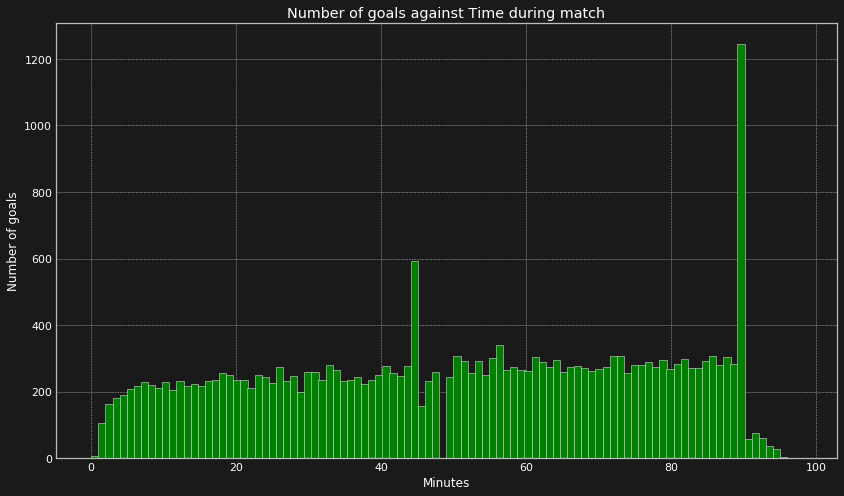

In [27]:
goals=df_unique_events[df_unique_events["is_goal"]==1]

fig4=plt.figure(figsize=(14,8))
plt.hist(goals.time,width=1,bins=100,color="green")   #100 so 1 bar per minute
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.title("Number of goals against Time during match")

In [87]:
goals

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Key Pass,Away,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,High and wide,Off target,False,Left side of the box,left foot,Pass,Open play,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,NaN,Home,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,NaN,Away,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,UNK,UNK,False,Defensive half,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
5,UFot0hit/,UFot0hit6,6,9,Hand ball by Jose Paolo Guerrero (Hamburg).,Hand ball,NaN,Away,Hamburg SV,Borussia Dortmund,jose paolo guerrero,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
6,UFot0hit/,UFot0hit7,7,10,"Corner, Hamburg. Conceded by Lukasz Piszczek.",Corner,NaN,Away,Hamburg SV,Borussia Dortmund,lukasz piszczek,lukasz piszczek,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
7,UFot0hit/,UFot0hit8,8,11,Chris Lowe (Borussia Dortmund) wins a free kic...,Free kick won,NaN,Home,Borussia Dortmund,Hamburg SV,chris lowe,NaN,NaN,NaN,UNK,UNK,False,Defensive half,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
8,UFot0hit/,UFot0hit9,9,11,Foul by Gojko Kacar (Hamburg).,Foul,NaN,Away,Hamburg SV,Borussia Dortmund,gojko kacar,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
9,UFot0hit/,UFot0hit10,10,13,Foul by Gokhan Tore (Hamburg).,Foul,NaN,Away,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,UNK,UNK,False,UNK,UNK,UNK,NaN,0,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN


### Comparison of goals in each league

In [28]:
no_goal=df_unique_events[df_unique_events["is_goal"]==0]
goal=df_unique_events[df_unique_events["is_goal"]==1]

goals=pd.concat([no_goal, goal])

player_no_goal = no_goal[['player','is_goal']]
player_no_goals = player_no_goal.groupby('player').count()

player_no_goals.columns = ['goal_False']

player_goal = goal[['player','is_goal']]
player_goals = player_goal.groupby('player').count()
player_goals.columns = ['goal_True']

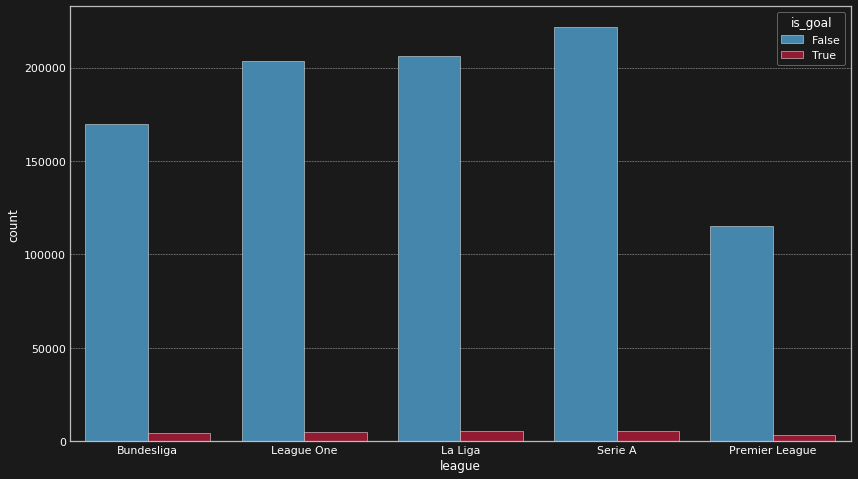

In [29]:
plt.figure(figsize=(14,8))
sns.countplot(x='league', hue='is_goal', data=goals)

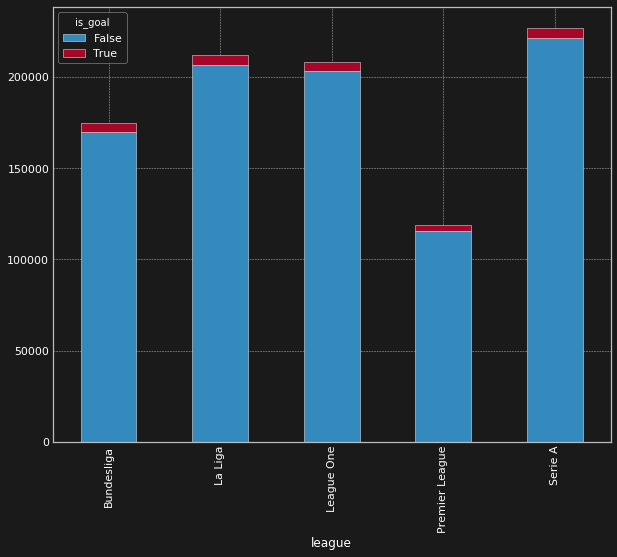

In [30]:
cross = pd.crosstab(index=goals.league, columns=goals.is_goal)
cross.plot(kind='bar', stacked=True, figsize=(10,8))

### Venn diagram to show how many players played in a league and how many played in both/all

In [31]:
AA = goals.player.groupby(goals.league)
names = list(AA.groups.keys())
labels = venn.get_labels([set(AA.get_group(names[i])) for i in range(5)], fill=['number', 'logic'])

In [32]:
labels

{'00001': '00001: 1150 ',
 '00010': '00010: 673 ',
 '00011': '00011: 61 ',
 '00100': '00100: 1326 ',
 '00101': '00101: 62 ',
 '00110': '00110: 69 ',
 '00111': '00111: 11 ',
 '01000': '01000: 1356 ',
 '01001': '01001: 124 ',
 '01010': '01010: 71 ',
 '01011': '01011: 19 ',
 '01100': '01100: 74 ',
 '01101': '01101: 7 ',
 '01110': '01110: 12 ',
 '01111': '01111: 1 ',
 '10000': '10000: 888 ',
 '10001': '10001: 36 ',
 '10010': '10010: 49 ',
 '10011': '10011: 8 ',
 '10100': '10100: 38 ',
 '10101': '10101: 4 ',
 '10110': '10110: 2 ',
 '10111': '10111: 0 ',
 '11000': '11000: 62 ',
 '11001': '11001: 6 ',
 '11010': '11010: 6 ',
 '11011': '11011: 1 ',
 '11100': '11100: 2 ',
 '11101': '11101: 0 ',
 '11110': '11110: 0 ',
 '11111': '11111: 1 '}

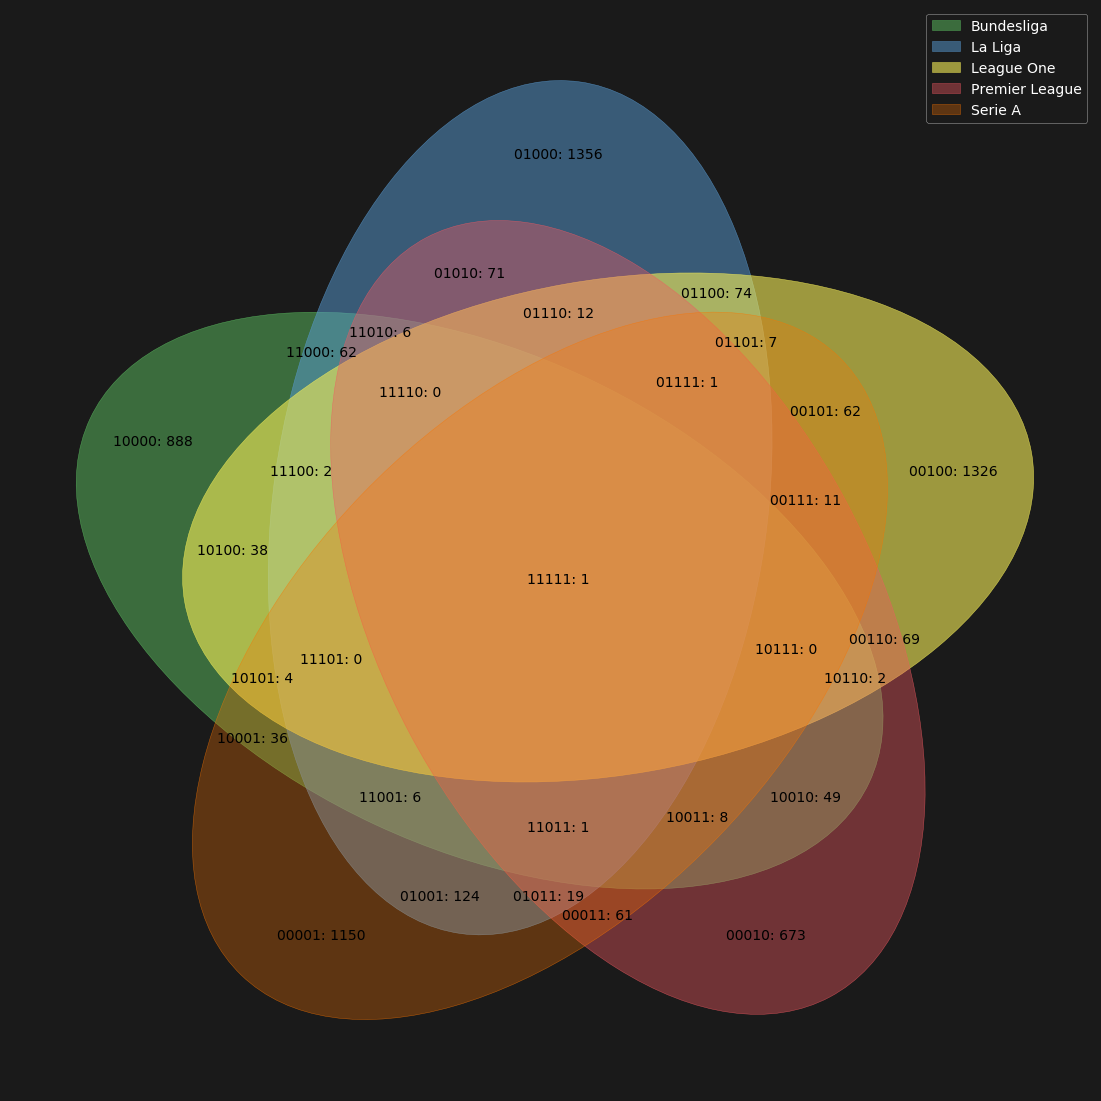

In [33]:
fig, ax = venn.venn5(labels, names=names, figsize=(20,20), fontsize=14)
fig.show()

In [34]:
players_events = pd.DataFrame(df_events.groupby('player').event_type.value_counts()).drop(['UNK'])
players_assist_methods = pd.DataFrame(df_events.groupby('player').assist_method.value_counts()).drop(['UNK'])
players_body_part = pd.DataFrame(df_events.groupby('player').bodypart.value_counts()).drop(['UNK'])
each_player_goals = pd.concat([player_no_goals, player_goals]).fillna(0).drop(['UNK'])


### Create a table of players with events, assist methods, goals and body parts

In [36]:
def get_list(list_type, players_event_type):
    col = list(list_type.values())
    col.insert(0, "player")

    player_list = pd.DataFrame(columns=(col))
    players_body_part = players_event_type.drop(index='UNK', level=1)
    players = players_body_part.index.unique(level=0)
    for i in range(len(players)):
        name = players[i]
        parts = players_body_part.loc[players[i]].get(players_event_type.columns[0])
        all_e = []
        for l in range(len(list_type.values())):   
            if list(list_type.values())[l] not in parts:
                parts[list(list_type.values())[l]] = 0                
            all_e.append(parts[list(list_type.values())[l]])               
        all_e.insert(0, name) 
        player_list.loc[i] =  all_e  
    return player_list    



In [37]:
all_players_body_parts = get_list(bodyparts, players_body_part)
all_players_event_types =  get_list(event_types, players_events)
all_players_assist_methods = get_list(assist_methods, players_assist_methods)
all_players_goals = each_player_goals

### Plot intensity of served cards, event_types, assist methods as per the players

Text(0, 0.5, 'Cards served per league')

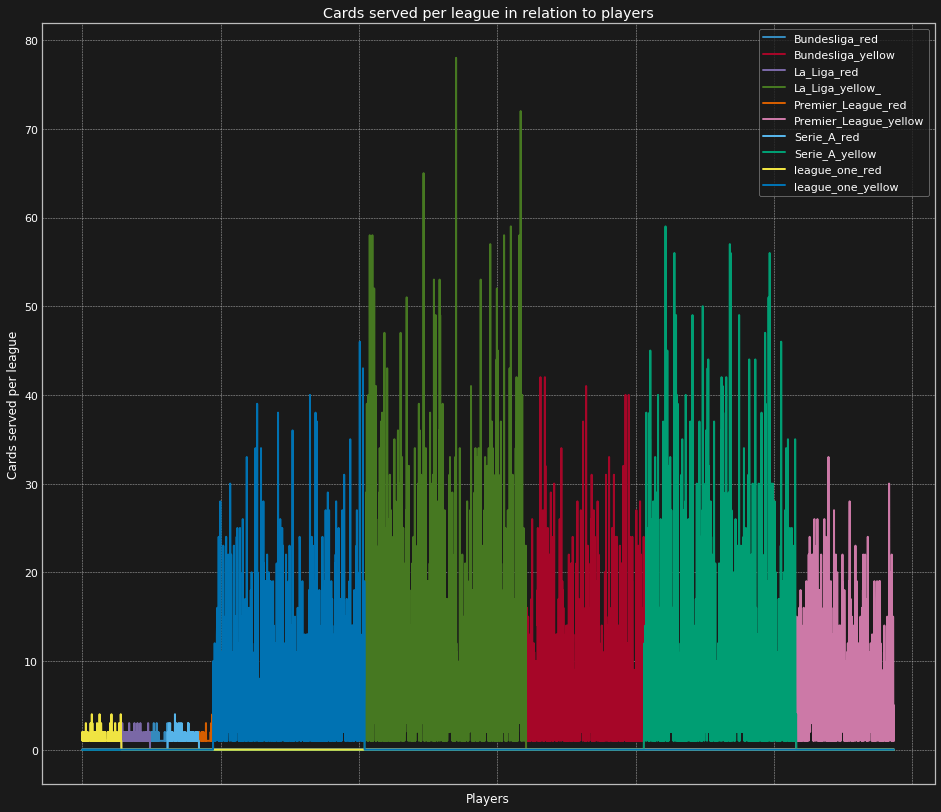

In [38]:
ax = cards_per_league.plot(figsize = [16,14], title = 'Cards served per league in relation to players')

ax.set_xlabel('Players', size =12)
ax.set_ylabel('Cards served per league', size =12)


Text(0, 0.5, 'Event types')

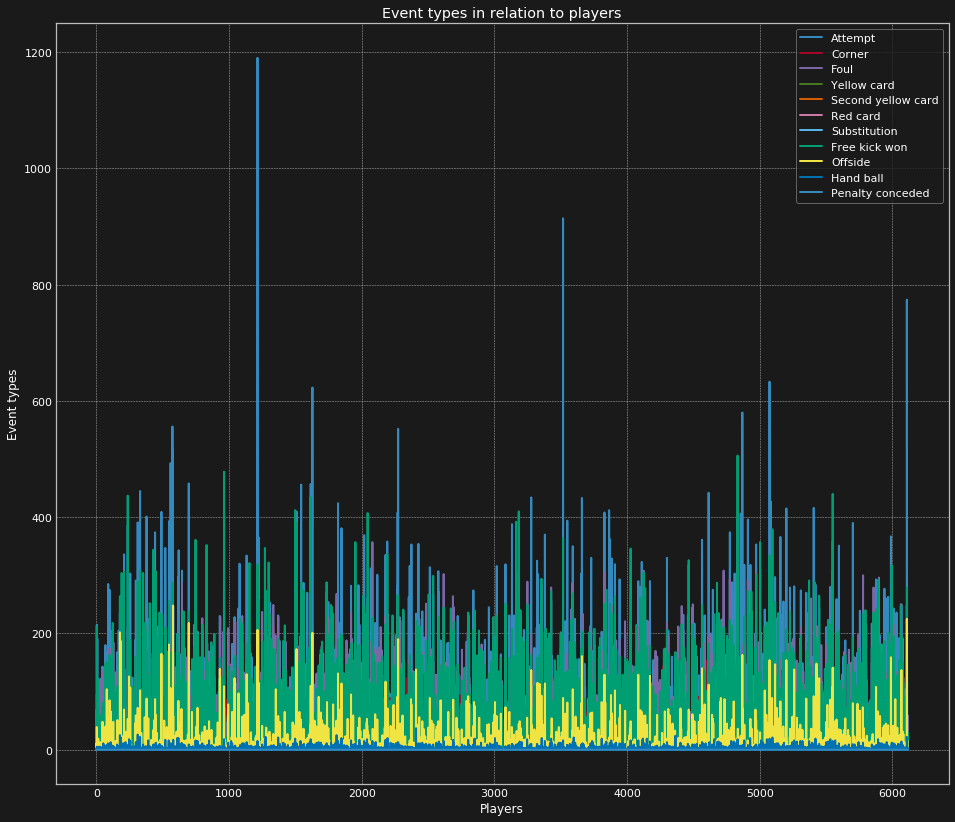

In [39]:
ax = all_players_event_types.plot(figsize = [16,14], title = 'Event types in relation to players')

ax.set_xlabel('Players', size =12)
ax.set_ylabel('Event types', size =12)


Text(0, 0.5, 'Assist Methods')

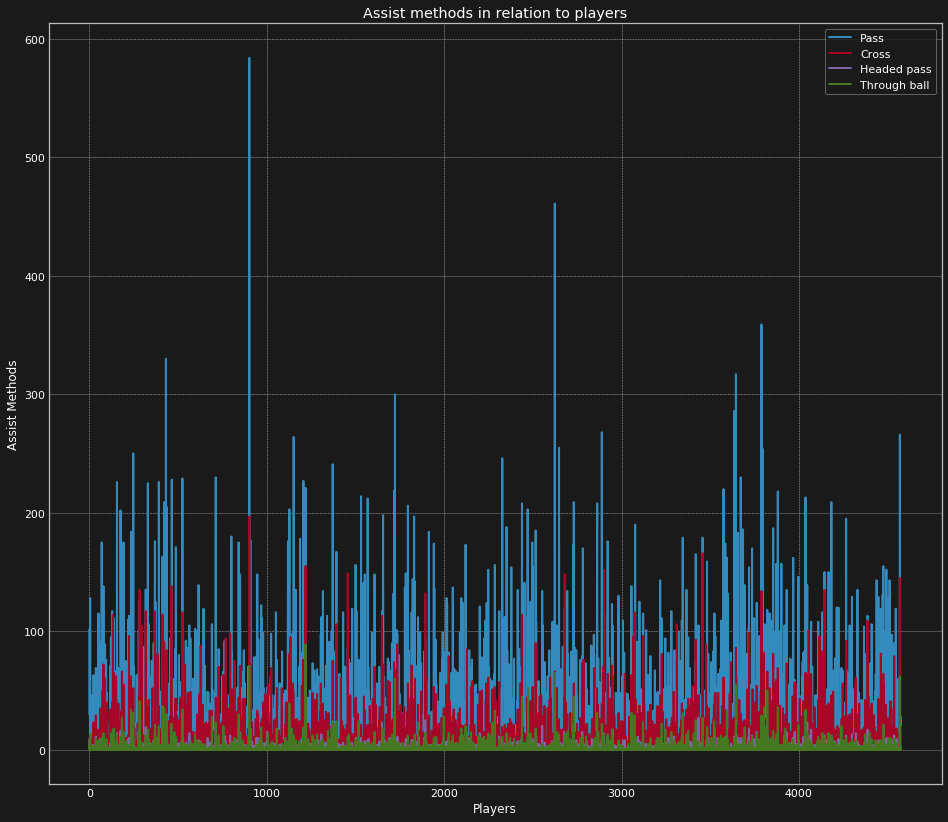

In [40]:
ax = all_players_assist_methods.plot(figsize = [16,14], title = 'Assist methods in relation to players')
ax.set_xlabel('Players', size =12)
ax.set_ylabel('Assist Methods', size =12)


Text(0, 0.5, 'Body Parts')

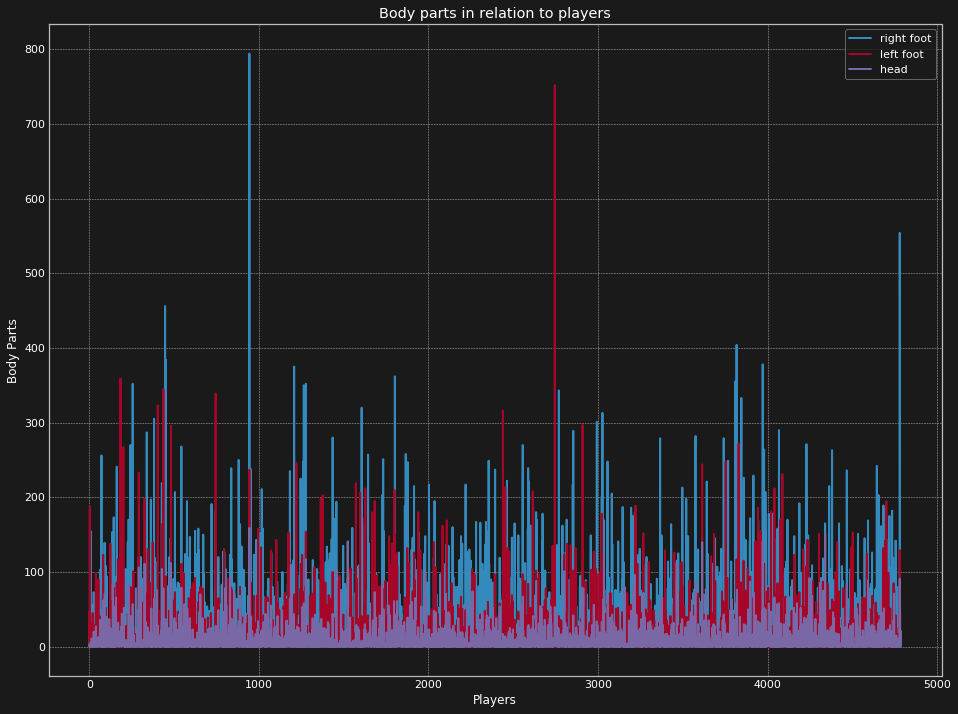

In [41]:
ax = all_players_body_parts.plot(figsize = [16,12], title = 'Body parts in relation to players')
ax.set_xlabel('Players', size =12)
ax.set_ylabel('Body Parts', size =12)

Text(0, 0.5, 'Goals')

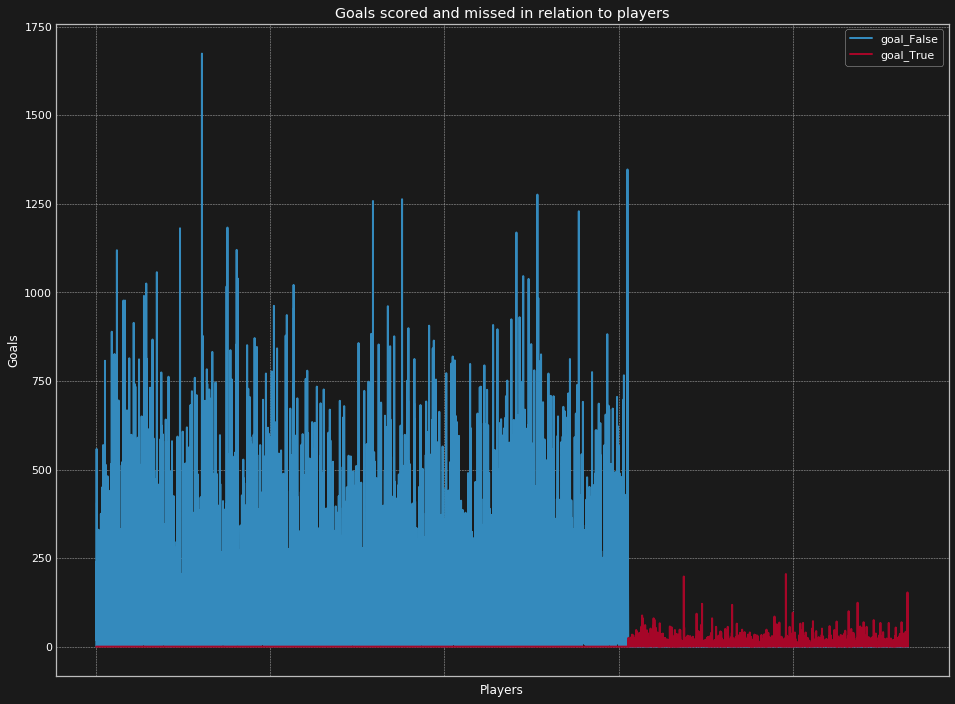

In [42]:
ax = all_players_goals.plot(figsize = [16,12], title = 'Goals scored and missed in relation to players')
ax.set_xlabel('Players', size =12)
ax.set_ylabel('Goals', size =12)


### How does getting a red card / yellow card / second yellow cards affect players' performance on the pitch

In [43]:
event_per_player = all_players_event_types.set_index('player')


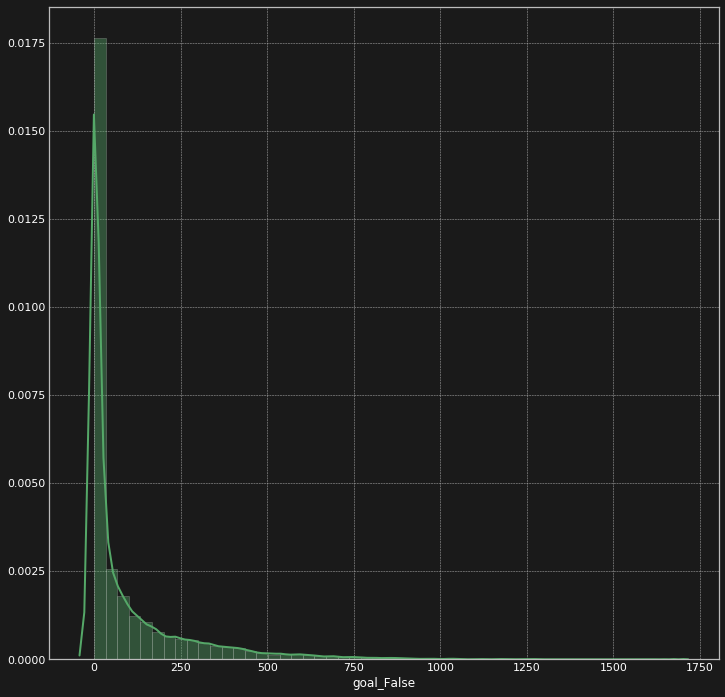

In [149]:
f, ax = plt.subplots(figsize=(12, 12))
all_players_goals.goal_True
sns.distplot(all_players_goals.goal_False, color='g')

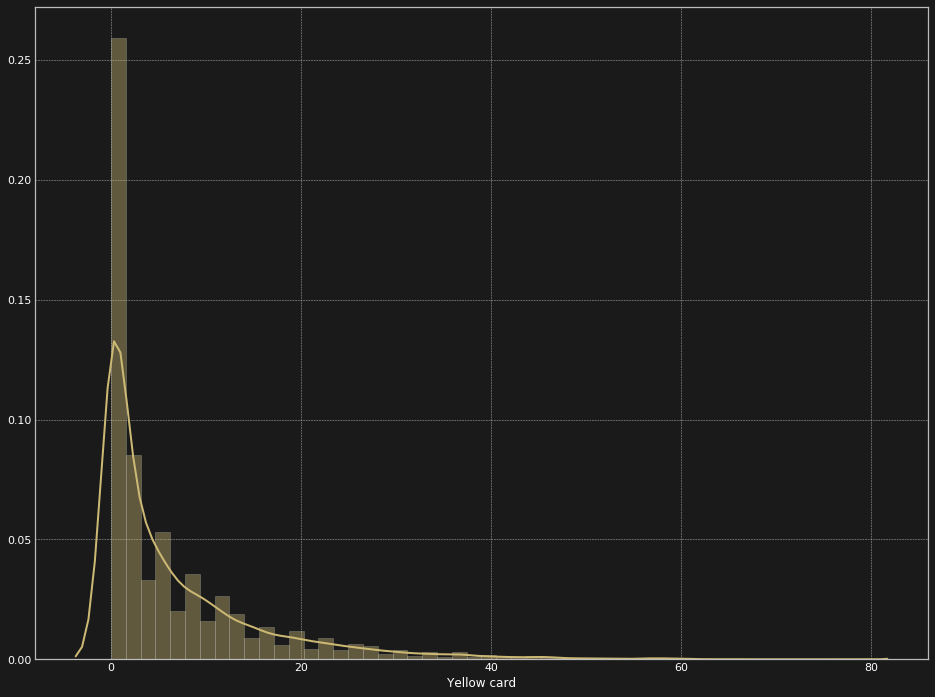

In [146]:
f, ax = plt.subplots(figsize=(16, 12))
sns.distplot(event_per_player['Yellow card'].astype(np.float), color='y')

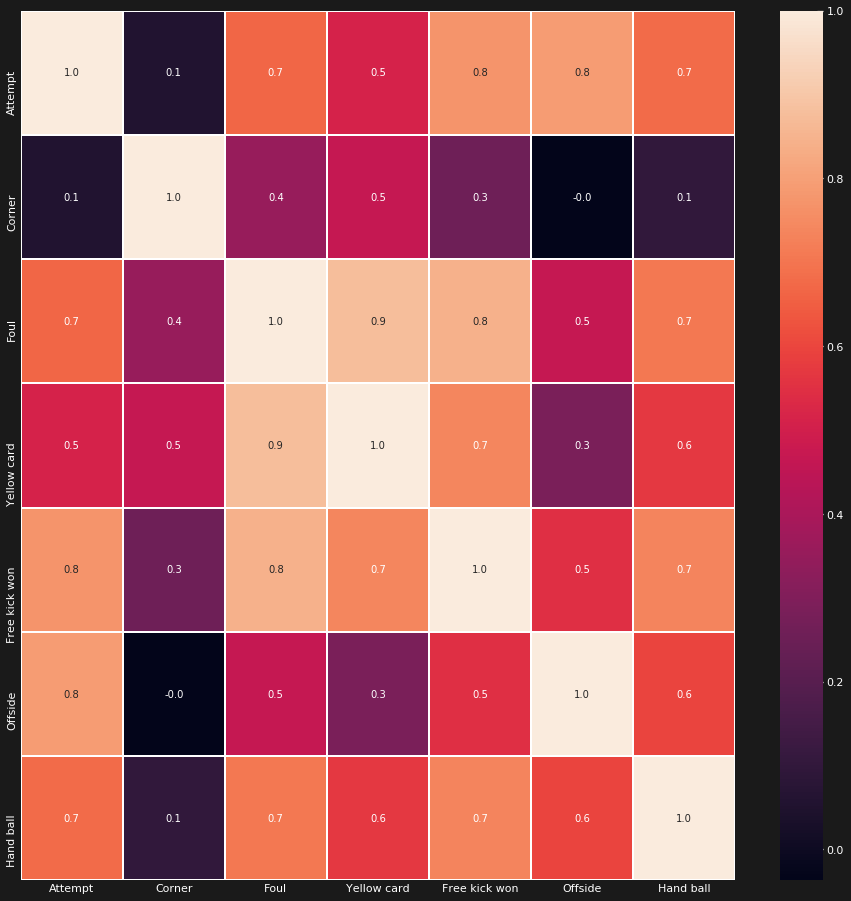

In [44]:
yellow_card_corr = (event_per_player.drop(['Red card', 'Substitution', 'Second yellow card', 'Penalty conceded'], axis=1)).astype(np.float)

f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(yellow_card_corr.corr(), linewidths=1, annot=True, fmt=".1f")

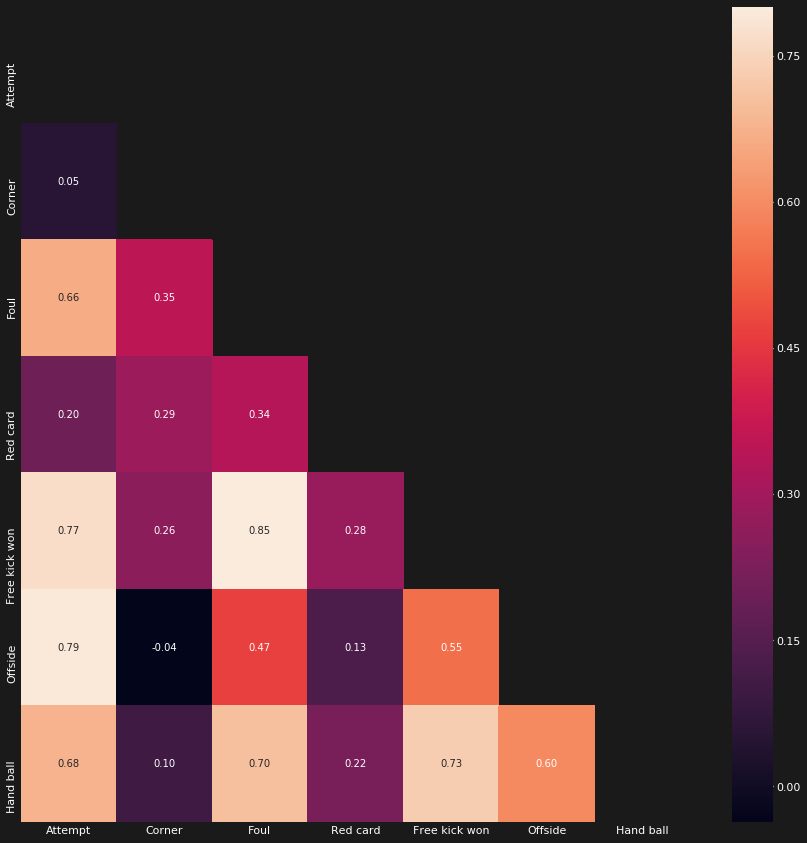

In [84]:
red_card_corr= (event_per_player.drop(['Yellow card', 'Substitution', 'Second yellow card', 'Penalty conceded'], axis=1)).astype(np.float)
mask = np.zeros_like(red_card_corr.corr())
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(red_card_corr.corr(), mask=mask, vmax=0.8, annot=True, fmt=".2f")


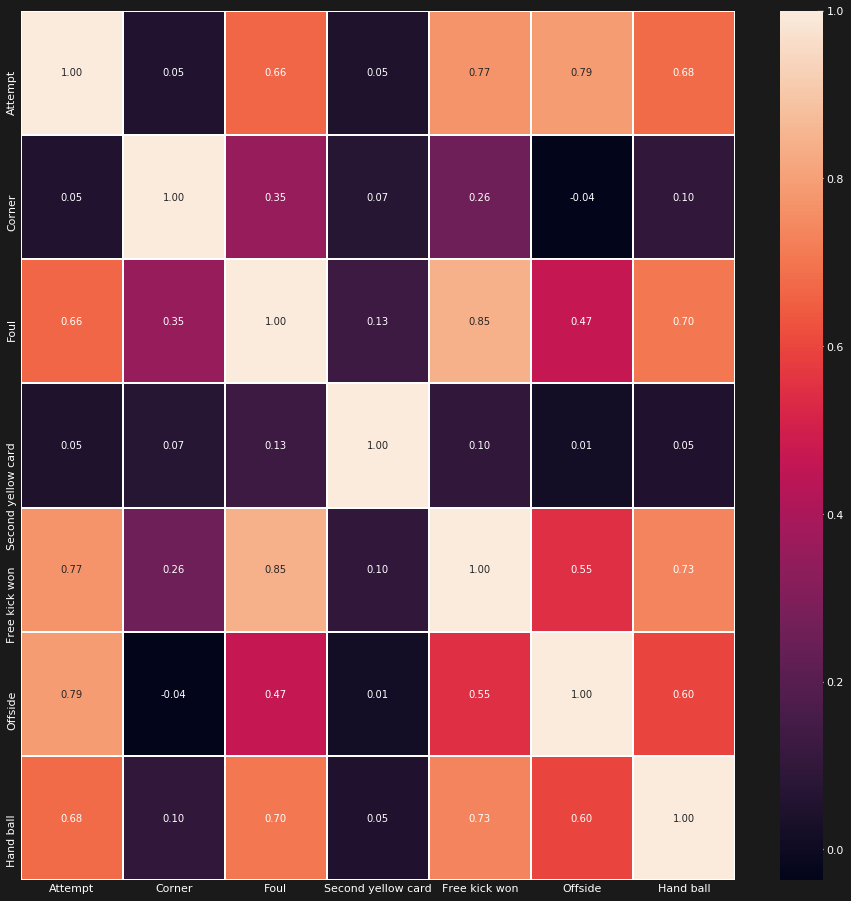

In [46]:
second_yellow_card_corr = (event_per_player.drop(['Yellow card', 'Substitution', 'Red card', 'Penalty conceded'], axis=1)).astype(np.float)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(second_yellow_card_corr.corr(), linewidths=1, annot=True, fmt=".2f")

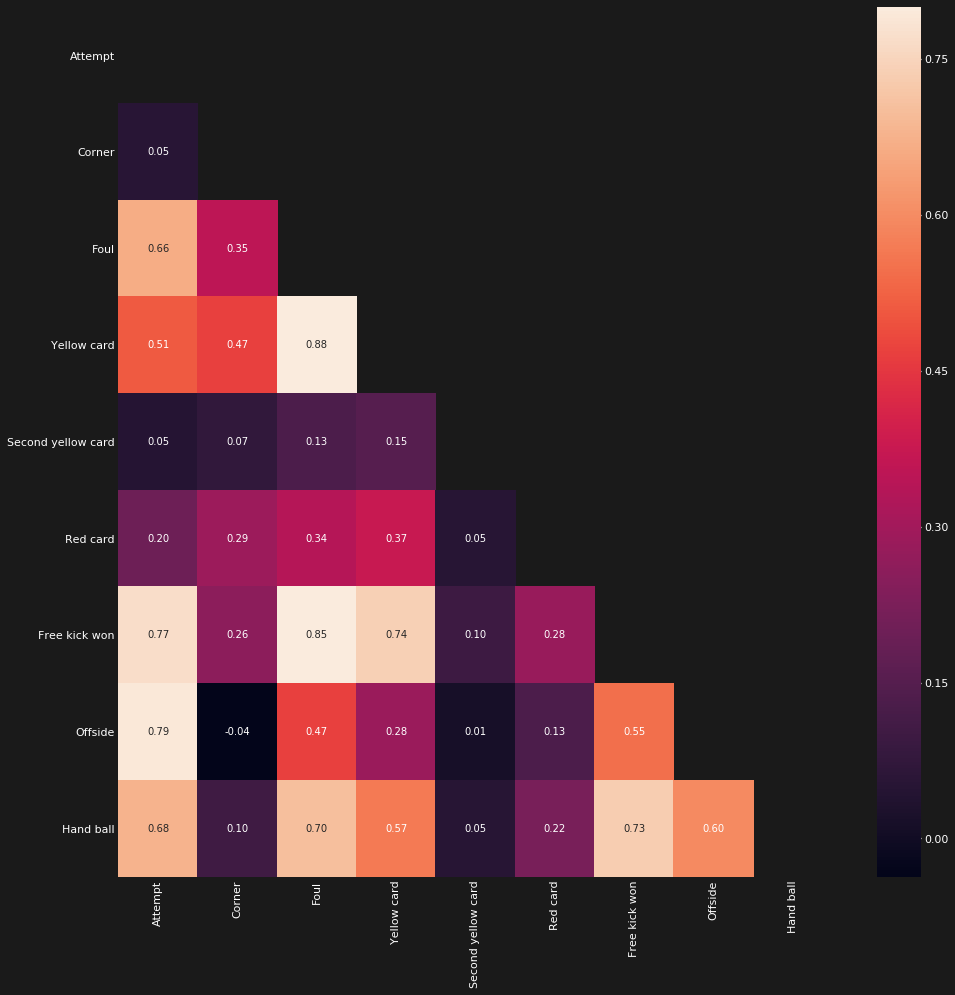

In [82]:
all_cards_corr= (event_per_player.drop(['Substitution', 'Penalty conceded'], axis=1)).astype(np.float)
corr = all_cards_corr.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, mask=mask, vmax=0.8, annot=True, fmt=".2f")

In [ ]:
# 

In [78]:
all_cards_corr_= (event_per_player.drop(['Substitution', 'Penalty conceded', 'Corner', 'Foul', 'Free kick won', 'Hand ball'], axis=1)).astype(np.float)


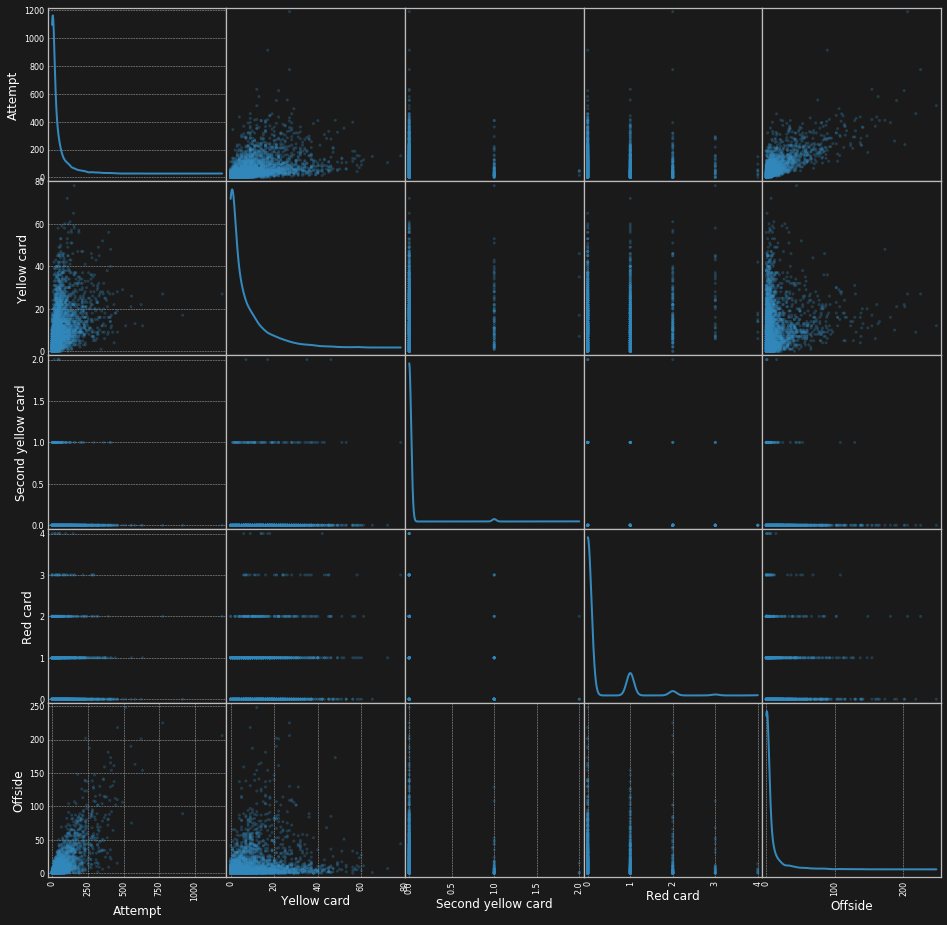

In [85]:
pd.scatter_matrix(all_cards_corr_, alpha = 0.3, figsize = (16,16), diagonal = 'kde');

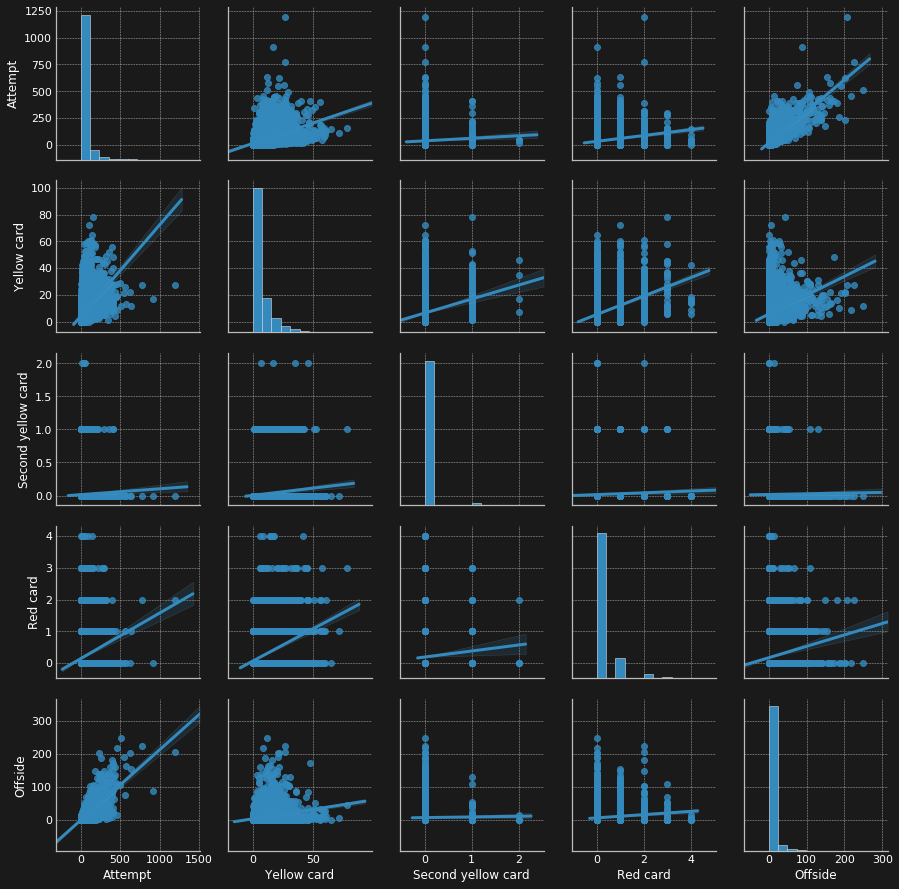

In [86]:
sns.pairplot(all_cards_corr_, kind="reg")